<a href="https://colab.research.google.com/github/joshikavita01/streamlit-demo/blob/master/Assignment3_Ques3(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
from PIL import Image , ImageOps


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
!unzip "/content/gdrive/MyDrive/cityscapes_data.zip" -d "/content/"

Archive:  /content/gdrive/MyDrive/cityscapes_data.zip
   creating: /content/cityscapes_data/
   creating: /content/cityscapes_data/train/
  inflating: /content/cityscapes_data/train/1.jpg  
  inflating: /content/cityscapes_data/train/10.jpg  
  inflating: /content/cityscapes_data/train/100.jpg  
  inflating: /content/cityscapes_data/train/1000.jpg  
  inflating: /content/cityscapes_data/train/1001.jpg  
  inflating: /content/cityscapes_data/train/1002.jpg  
  inflating: /content/cityscapes_data/train/1003.jpg  
  inflating: /content/cityscapes_data/train/1004.jpg  
  inflating: /content/cityscapes_data/train/1005.jpg  
  inflating: /content/cityscapes_data/train/1006.jpg  
  inflating: /content/cityscapes_data/train/1007.jpg  
  inflating: /content/cityscapes_data/train/1008.jpg  
  inflating: /content/cityscapes_data/train/1009.jpg  
  inflating: /content/cityscapes_data/train/101.jpg  
  inflating: /content/cityscapes_data/train/1010.jpg  
  inflating: /content/cityscapes_data/train/

In [6]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
x = list()
y = list()
num_images = 400

image_directory = '/content/cityscapes_data/train'
image_filenames = os.listdir( image_directory )
for f in image_filenames[ 0 : 100 ]:
	i = Image \
		.open(os.path.join( image_directory, f))
	x.append( np.asarray( ImageOps.crop( i , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) )
	y.append(np.asarray( ImageOps.crop(i, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) ))

x = np.array( x ) / 255
y = np.array( y )

training_features, testing_features, training_labels, testing_labels = train_test_split(np.array(x), np.array(y),
																					test_size=0.4)

def binary( pixel ):
    if np.array_equal( pixel , [ 128 , 63 , 127 ]):
        return np.array( [ 1 ] )
    else :
        return np.array( [ 0 ] )

training_labels = np.apply_along_axis( binary , axis=3 , arr=training_labels ) 
testing_labels = np.apply_along_axis( binary , axis=3 , arr=testing_labels ) 

batch_size = 5

training_dataset = tf.data.Dataset.from_tensor_slices( ( training_features , training_labels ) )
training_dataset = training_dataset.shuffle( 1024 ).batch( batch_size )
testing_dataset = tf.data.Dataset.from_tensor_slices( ( testing_features , testing_labels ) )
testing_dataset = testing_dataset.shuffle( 1024 ).batch( batch_size )

In [7]:
relu_alpha = 0.2 
dropout_rate = 0.5  
padding = 'SAME'
def conv2d_downn( i , f, ss ):
    
    out_1 = tf.nn.conv2d( i , f , strides=ss, padding=padding ) 
    return tf.nn.leaky_relu( out_1 , alpha=0.2 ) 

def maxpool_downn( i , ps , ss ):
    
    return tf.nn.max_pool( i , ksize=ps , padding='VALID' , strides=ss )

def conv2d_upp( i , f , ss , os ):
   
    out = tf.nn.conv2d_transpose( i, f , output_shape=os , strides=ss , padding=padding ) 
    return tf.nn.leaky_relu( out_1 , alpha=0.2 ) 

def maxpool_upp( i , s ):
    
    input_dimension = tf.shape( i)[ 1 ]
    output_dimension = tf.cast( tf.round( input_dimension * s ) , dtype=tf.int32 ) 
    return tf.image.resize( i , [ output_dimension , output_dimension ] , method='nearest' ) 


In [9]:
from tensorflow.python.framework.ops import init_scope
init = tf.initializers.glorot_uniform()
def _weight( s, n ):
    return tf.Variable( init_scope( s ) , name=n, trainable=True )

s = [
    [ 3 , 3 , 3 , 16 ] , 
    [ 3 , 3 , 16 , 16 ] , 

    [ 3 , 3 , 16 , 32 ] , 
    [ 3 , 3 , 32 , 32 ] ,

    [ 3 , 3 , 32 , 64 ] , 
    [ 3 , 3 , 64 , 64 ] ,

    [ 3 , 3 , 64 , 128 ] , 
    [ 3 , 3 , 128 , 128 ] ,

    [ 3 , 3 , 128 , 256 ] , 
    [ 3 , 3 , 256 , 256 ] ,

    [ 3 , 3 , 128 , 384 ],
    [ 3 , 3 , 128 , 128 ],

    [ 3 , 3 , 64 , 192 ],
    [ 3 , 3 , 64 , 64 ],

    [ 3 , 3 , 32 , 96 ],
    [ 3 , 3 , 32 , 32 ],

    [ 3 , 3 , 16 , 48 ],
    [ 3 , 3 , 16 , 16 ],

    [ 1 , 1 , 16 , 1 ],
]

w = []
for i in range( len( s ) ):
    w.append( _weight( s[ i ] , 'weight{}'.format( i ) ) )


In [10]:

def model( x ) :
    batch_size = tf.shape( x )[0]
    x = tf.cast( x , dtype=tf.float32 )
    c1 = conv2d_downn( x , w[ 0 ] , ss=1 ) 
    c1 = conv2d_downn( c1 , w[ 1 ] , ss=1 ) 
    p1 = maxpool_downn( c1 , ps=2 , ss=2 )
    
    c2 = conv2d_downn( p1 , w[ 2 ] , ss=1 )
    c2 = conv2d_downn( c2 , w[ 3 ] , ss=1 ) 
    p2 = maxpool_downn( c2 , ps=2 , ss=2 )
    
    c3 = conv2d_downn( p2 , w[ 4 ] , ss=1 ) 
    c3 = conv2d_downn( c3 , w[ 5 ] , ss=1 ) 
    p3 = maxpool_downn( c3 , ps=2 , ss=2 )
    
    c4 = conv2d_downn( p3 , w[ 6 ] , ss=1 )
    c4 = conv2d_downn( c4 , w[ 7 ] , ss=1 )
    p4 = maxpool_downn( c4 , ps=2 , ss=2 )

    c5 = conv2d_downn( p4 , w[ 8 ] , ss=1 )
    c5 = conv2d_downn( c5 , w[ 9 ] , ss=1 ) 
        
    p5 = maxpool_upp( c5 , 2 )
    concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
    c6 = conv2d_upp( concat_1 , w[ 10 ] , ss=1 , os=[ batch_size , 16 , 16 , 128 ] )
    c6 = conv2d_upp( c6 , w[ 11 ] , ss=1 , os=[ batch_size , 16 , 16 , 128 ] )  

    p6 = maxpool_upp( c6 , 2 )
    concat_2 = tf.concat( [ p6 , c3 ] , axis=-1 ) 
    c7 = conv2d_upp( concat_2 , w[ 12 ] , ss=1 , os=[ batch_size , 32 , 32 , 64 ] )
    c7 = conv2d_upp( c7 , w[ 13 ] , ss=1 , os=[ batch_size , 32 , 32 , 64 ] )  

    p7 = maxpool_upp( c7 , 2 )
    concat_3 = tf.concat( [ p7 , c2 ] , axis=-1 ) 
    c8 = conv2d_upp( concat_3 , w[ 14 ] , stride_size=1 , os=[ batch_size , 64 , 64 , 32 ] )
    c8 = conv2d_upp( c8 , w[ 15 ] , stride_size=1 , os=[ batch_size , 64 , 64 , 32 ] )   

    p8 = maxpool_upp( c8 , 2 )
    concat_4 = tf.concat( [ p8 , c1 ] , axis=-1 ) 
    c9 = conv2d_upp( concat_4 , w[ 16 ] , ss=1 , os=[ batch_size , 128 , 128 , 16 ] )
    c9 = conv2d_upp( c9 , w[ 17 ] , ss=1 , os=[ batch_size , 128 , 128 , 16 ] )   

    output = tf.nn.conv2d( c9 , w[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] , padding=padding ) 
    outputs = tf.nn.sigmoid( output ) 
    return outputs


In [11]:

def loss( pred , target ):
    return tf.losses.binary_crossentropy( target , pred )


lr= "0.001"
optimizer = tf.optimizers.Adam( learning_rate=float( lr ) )

def train( model, inputs , outputs ):
    with tf.GradientTape() as tape:
        closs = loss( model( inputs ), outputs)
    grads = tape.gradient( closs , w )
    optimizer.apply_gradients( zip( grads , w ) )
    return tf.reduce_mean( closs )


In [12]:
  
import datetime

logdirectory = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer( logdirectory + "/metrics")
file_writer.set_as_default()

num_epochs = 25 

for e in range( num_epochs ):
    print( 'Epoch {} out of {} {}'.format( e + 1 , num_epochs , '--' * 50 ) )
    for f in training_dataset:
        image , label = f
        summ_loss = train( model , image , label )
        tf.summary.scalar('loss', data=summ_loss, step=e )


Epoch 1 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 2 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 3 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 4 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 5 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 6 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 7 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 8 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 9 out of 25 ------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


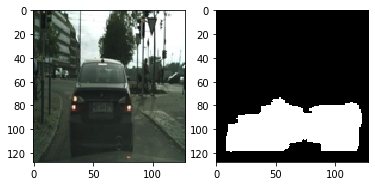

In [13]:
import matplotlib.pyplot as plt
_image = testing_features[0:1]
prediction = model(_image ).numpy()
image = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):
        if prediction[ 0 , x , y ] > 0.5:
            image[ x , y ] = [ 255 , 255 , 255 ]
        else:
            image[ x , y ] = [ 0, 0, 0]

def show_images(images: list):
    n = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i] , interpolation='none' )
    plt.show()

show_images( [ testing_features[0] , image ] )

In [14]:
from keras import backend as k
def dice_coef(y_true, y_pred, smooth = 1):
  y_true_f = k.flatten(y_true)
  y_pred_f = k.flatten(y_true)
  intersection = k.sum(y_true_f *y_pred_f)
  print(2. * intersection + smooth) / (k.sum(y_true_f) +k.sum(y_pred_f) +smooth)

In [ ]:
dice_coef(testing_features[0] , image, smooth = 1)

In [ ]:
def iou(y_true, y_pred):
  y_true_f = k.flatten(y_true)
  y_pred_f = k.flatten(y_true)
  inter = k.sum(y_true_f *y_pred_f)
  union = k.sum(y_true_f) +k.sum(y_pred_f) - inter
  print(inter/union)

In [ ]:
iou(testing_features[0] , image)